# 04_Flood_Depth_Estimation: Trucks

This model heavily leverages the work of the VGG-16 model, published as

Very Deep Convolutional Networks for Large-Scale Image Recognition    
K. Simonyan, A. Zisserman    
arXiv:1409.1556

This model became very popular because it reported >90% accuracy on several test sets. It has been successfully used on a number of other test sets since then.

Implementation and enhancement examples from the following sources were also used, including methods to save and restore models, weights, augment images, and exit early from a training session.

 - https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
 - https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
 - https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
 
Building on the material from these sources, we have modified the code, built additional utilities, and generally customized everything.

## Contents:    
 - Notebook Setup
 - Image Setup
 - Model Build
 - Model Train
 - Model Evaluation
 - Preliminary Model Test

## Import

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


## Global settings

In [2]:
# These are the settings to adjust as new models are tried
model_name_for_saving = 'vgg16m_truck_3_v1.h5'

model_weights_for_saving = 'vgg16w_truck_3_v1.h5'

checkpoint_model_name = 'vgg16m_truck_checkpoint.h5'

In [3]:
# Images for training the model
train_dir = '../images/truck/train'

# Images for validating the model (testing it during the training phases)
validate_dir = '../images/truck/validate'

# After the model has been built, try it out on a few images it hasn't seen
image_test_dir = '../images/truck/test'

## Utility functions

In [4]:
# Remove .DS_store from the list of files in a directory
def rm_DS(mlist): 
    if ('.DS_Store' in mlist): mlist.remove('.DS_Store')
    return mlist

## Image setup

The folder structure beneath each of the train, validate, and test directories is identical, and each folder represents a category for classification.

We have standardized on estimating flood depths as

|Category|Meaning|
|---|---|
|depth_0| No water, or surface water on the order of 1 inch.|
|depth_1| 1 foot, or approximately the middle of a hubcap.|
|depth_2| 2 feet, or approximately the top of a tire.|
|depth_3| 3 feet, or roughly just below the rear view mirrors or the top of the door.|
|depth_4| 4 feet, or above the truck bed but below the roof line.|

In [5]:
!ls {train_dir}  # folders in the train_dir indicate the classification categories 

depth_0 depth_1 depth_2 depth_3 depth_4


In [6]:
# Programmatically get the class labels from the training directory
category_list = rm_DS(os.listdir(image_test_dir))
labels = sorted(category_list)
num_categories = len(labels)

print(f"Classification labels to predict: {labels}")

Classification labels to predict: ['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4']


In [7]:
# Count the number of images in each category; determine the baseline model
image_train_dirs = os.listdir(train_dir)

category_dict = dict()
total_images = 0

for itdir in image_train_dirs:
    checkdir = train_dir + '/' + itdir
    if (itdir != '.DS_Store'):
        num_images = len(os.listdir(checkdir))
        category_dict[itdir] = num_images
        total_images += num_images
        
print(f"Total images: {total_images}")
baseline = 0
for k,v in category_dict.items():
    prcnt = round(100*v/total_images,1)
    print(f"Category {k} has {v: 3d} images or {prcnt}% of the images.")
    if prcnt > baseline: baseline = prcnt
        
print(f"\nBaseline accuracy: {baseline}%")
print(f"(accuracy achieved by simply guessing the most populous category)")

Total images: 116
Category depth_2 has  24 images or 20.7% of the images.
Category depth_3 has  21 images or 18.1% of the images.
Category depth_4 has  25 images or 21.6% of the images.
Category depth_1 has  24 images or 20.7% of the images.
Category depth_0 has  22 images or 19.0% of the images.

Baseline accuracy: 21.6%
(accuracy achieved by simply guessing the most populous category)


## Image pre-processing

Inspiration for ways to augment a small data set:
    
 - https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
    
 - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html   

TODO: Update and reword the following. The text is from the TDS implementation of the VGG-16 model.

The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. This class alters the data on the go while passing it to the model.

TODO: REPLACE THIS IMAGE. The text is from the TDS implementation of the VGG-16 model.


Problem -- for some reason, this seems to expect the data to be in separate directories for 'cat' or 'dog' under the train and test folders. See the image in this folder

<img src="../images/dogs-vs-cats/tds_folder_structure.png" alt="folder structure" width="750"/>

**ImageDataGenerator**

When working with a small number of images, one option is to randomly transform the images (by reasonable amounts) to imitate having a larger data set.

In the following section, the ImageDataGenerator will be configured to include
 - width_shifts (side to side shifts of the image)
 - height
 
TODO: Complete this exlanation box; okay to refer again to outside sources 

In [8]:
# The bulk of the images are in this training set
trdata = ImageDataGenerator(
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            channel_shift_range = 0.0, # 0.0 no RGB shifts
                            rotation_range=4,
                            horizontal_flip=True
)
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(224,224))


# This data is used to validate the model during training
tsdata = ImageDataGenerator(
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rotation_range=4,
                            horizontal_flip=True
                           )
testdata = tsdata.flow_from_directory(directory=validate_dir, target_size=(224,224))

Found 114 images belonging to 5 classes.
Found 32 images belonging to 5 classes.


In [9]:
base_test_images = len(testdata.next()[0])
base_test_images

32

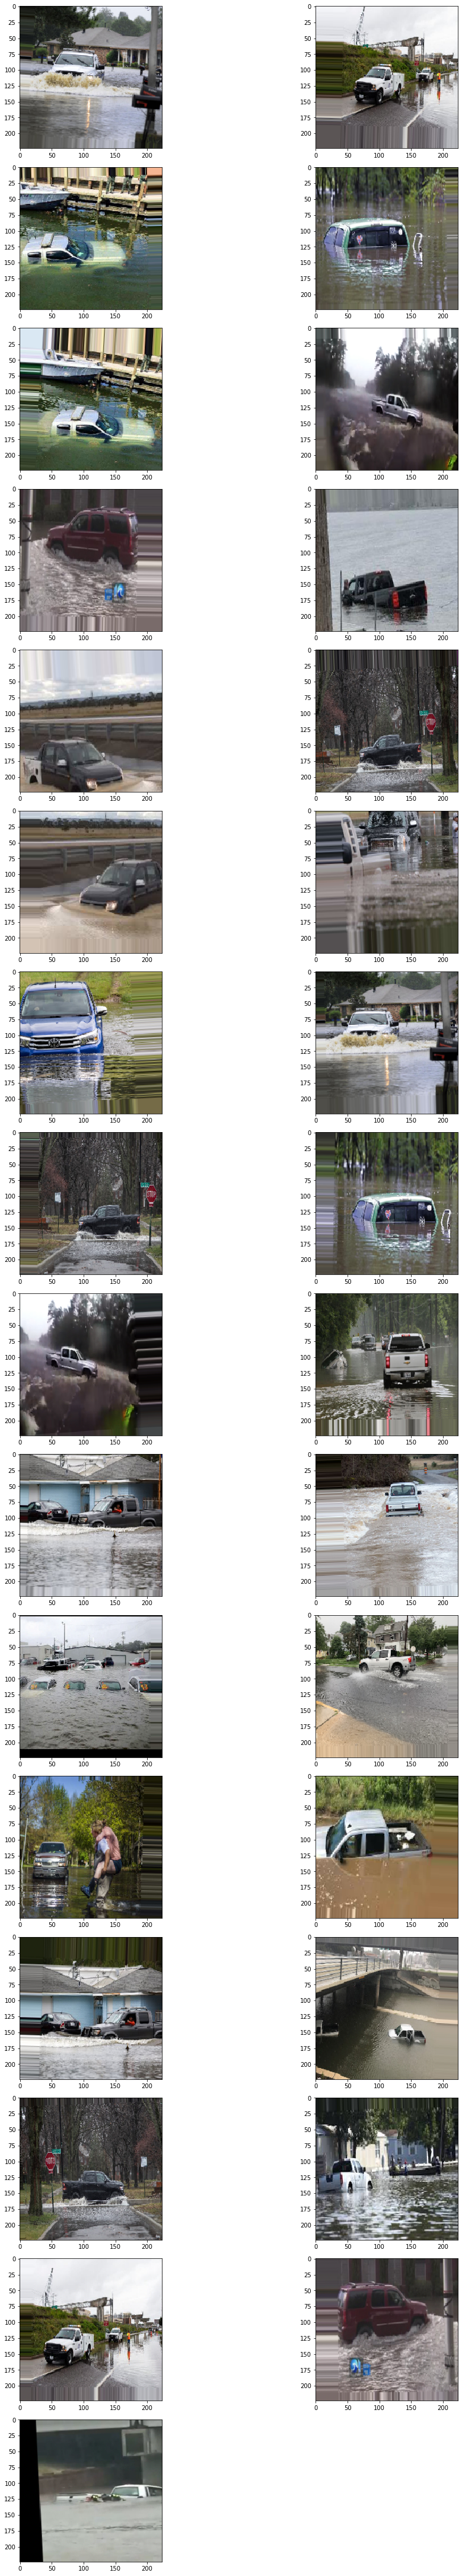

In [10]:
num_test_images = base_test_images

# take a quick look at the the testdata images
fig = plt.figure(figsize=(14,2*num_test_images))

#it = testdata.flow(batch_size=1)
img_count = 1;

for i in range(num_test_images-1):
    ax = fig.add_subplot((num_test_images/2)+1,2,img_count)
    
    getphoto = testdata.next()
    getimg = getphoto[0].astype('uint8')[img_count]
    ax.imshow(getimg)
    img_count += 1
plt.tight_layout()
    

# Build the model

TODO: Update and reword the following. The text is from the TDS implementation of the VGG-16 model.

Here I have started with initialising the model by specifying that the model is a sequential model. After initialising the model I add
→ 2 x convolution layer of 64 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 2 x convolution layer of 128 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 256 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
I also add relu(Rectified Linear Unit) activation to each layers so that all the negative values are not passed to the next layer.

In [11]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", 
                 activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

TODO: Update and reword the following. The text is from the TDS implementation of the VGG-16 model.

After creating all the convolution I pass the data to the dense layer so for that 
I flatten the vector which comes out of the convolutions and add    
→ 1 x Dense layer of 4096 units    
→ 1 x Dense layer of 4096 units    
→ 1 x Dense Softmax layer of 2 units    
I will use RELU activation for both the dense layer of 4096 units so that I stop 
forwarding negative values through the network. I use a 2 unit dense layer in the 
end with softmax activation as I have 2 classes to predict from in the end which are dog and cat. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.

In [12]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_categories, activation="softmax")) # needs to be the same as the num classes

At the end of the cell above, the "softmax" activation layer contains the name number of nodes as the 'num_categories', and this is where the final classification will occur. At this point, the model layers have been built. The next step is to compile the model.

In [13]:
# Compile the model with the model parameters
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy']                        # other metrics to produce
             )

'Adam' is a popular optimiser for finding the global minimum of the loss function.

The learning rate may be adjusted 
- lower, if the results are changing drastically from epoch to epoch
- higher, if the model runs for a very long time and doesn't make very much progress from epoch to epoch

During development, we tried

- 0.001 after 25 epochs, 1.0 on training 0.3 on validation
- 0.0005

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

**ModelCheckpoint and EarlyStopping**      
These methods can be called during model training ('callback functions'). 

**ModelCheckpoint**     
This function will monitor a selected parameter and save a copy of the model if there was an improvment from the prior epoch to the current epoch. If the paramter stops improving, changes in the model will not be saved. In essence, this captures the model that provided the best results (for the selected parameter) during the training sessions.

**EarlyStopping**    
This function can terminate training early if the progress is too slow. It will monitor the selected parameter, be patient enough to wait for a specified number of epochs, and then stop the training if parameter hasn't improved.

In [15]:
# Fit the model

# Save the model if the validation accuracy has improved over the previous epoch
checkpoint = ModelCheckpoint(checkpoint_model_name, monitor='val_acc', verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

# Stop training early if the validation accuracy has not improved
early = EarlyStopping(monitor='val_acc',    # parameter to monitor
                      min_delta=0,          # minimum improvment
                      patience=20,          # how many epochs to wait
                      verbose=1, mode='auto')

use_epochs = 25 # original had 100
#steps_per_epoch = train_images / use_epochs # calculate well or leave it blank

m_history = model.fit_generator(
                           #steps_per_epoch=use_epochs,
                           generator=traindata,           # training images
                           validation_data= testdata,     # validation images
                           validation_steps=10,           #
                           epochs=use_epochs,             # training cycles
                           callbacks=[checkpoint,early]
                    )

Epoch 1/25
4/4 [==============================] - 48s 12s/step - loss: 2.4172 - accuracy: 0.2368 - val_loss: 1.7107 - val_accuracy: 0.1562
Epoch 2/25


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4/4 [==============================] - 50s 12s/step - loss: 1.6493 - accuracy: 0.2105 - val_loss: 1.6121 - val_accuracy: 0.1875
Epoch 3/25
4/4 [==============================] - 51s 13s/step - loss: 1.6122 - accuracy: 0.2193 - val_loss: 1.6166 - val_accuracy: 0.1875
Epoch 4/25
4/4 [==============================] - 51s 13s/step - loss: 1.6120 - accuracy: 0.2193 - val_loss: 1.6002 - val_accuracy: 0.1875
Epoch 5/25
4/4 [==============================] - 51s 13s/step - loss: 1.6090 - accuracy: 0.2193 - val_loss: 1.6068 - val_accuracy: 0.1875
Epoch 6/25
4/4 [==============================] - 51s 13s/step - loss: 1.6080 - accuracy: 0.2018 - val_loss: 1.6153 - val_accuracy: 0.1719
Epoch 7/25
4/4 [==============================] - 51s 13s/step - loss: 1.6007 - accuracy: 0.2105 - val_loss: 1.6064 - val_accuracy: 0.1719
Epoch 8/25
4/4 [==============================] - 51s 13s/step - loss: 1.5992 - accuracy: 0.1842 - val_loss: 1.5825 - val_accuracy: 0.3438
Epoch 9/25
4/4 [======================

## Evaluate the model

During training and validation, the accuracy and loss were stored in 'm_history'. This information can now we used to examine the progress of the model. This is most useful during development and training.

In [16]:
type(m_history)

keras.callbacks.callbacks.History

In [17]:
# Optional peek at the contents of the model history
m_history.history

{'val_loss': [1.7107090950012207,
  1.6120729446411133,
  1.616624116897583,
  1.6002225875854492,
  1.606811285018921,
  1.6152726411819458,
  1.606388807296753,
  1.5824646949768066,
  1.6067628860473633,
  1.5907013416290283,
  1.613963007926941,
  1.5459582805633545,
  1.5483132600784302,
  1.594377040863037,
  1.5533292293548584,
  1.7101961374282837,
  1.5668216943740845,
  1.5591676235198975,
  1.5141043663024902,
  1.5545411109924316,
  1.5813500881195068,
  1.5862228870391846,
  1.4843127727508545,
  1.4858334064483643,
  1.5546605587005615],
 'val_accuracy': [0.15625,
  0.1875,
  0.1875,
  0.1875,
  0.1875,
  0.171875,
  0.171875,
  0.34375,
  0.203125,
  0.28125,
  0.28437501192092896,
  0.2593750059604645,
  0.32499998807907104,
  0.2874999940395355,
  0.22187499701976776,
  0.2562499940395355,
  0.3531250059604645,
  0.21562500298023224,
  0.21250000596046448,
  0.2562499940395355,
  0.2562499940395355,
  0.28437501192092896,
  0.296875,
  0.33125001192092896,
  0.3125],
 

(0, 1.1768003821961188)

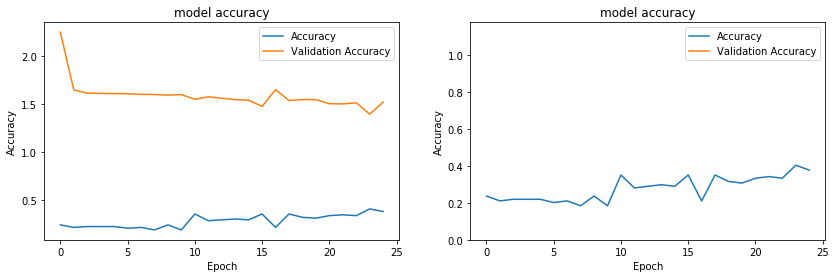

In [26]:
# Plot the coarse and fine versions of the model improvements

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,1)

#plt.plot(hist.history["acc"])
ax1.plot(m_history.history['accuracy'])
#plt.plot(hist.history['val_acc'])
ax1.plot(m_history.history['loss'])
#plt.plot(hist.history['val_loss'])
ax1.set_title("model accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

# get ylimits and consider zooming in for the next plot
ylow, yhigh = ax1.get_ylim()

ax2 = fig.add_subplot(1,2,2)

#plt.plot(hist.history["acc"])
ax2.plot(m_history.history['accuracy'])
#plt.plot(hist.history['val_acc'])
ax2.plot(m_history.history['loss'])
#plt.plot(hist.history['val_loss'])
ax2.set_title("model accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
ax2.set_ylim(0,yhigh/2)

In [19]:
# TODO: get the data from the history to plot a confusion matrix -- at least, i think it is in the history

In [20]:
# save the model
model.save(filepath=model_name_for_saving)   # this is a very large file -- > 1.5G

In [21]:
# save just the weights?
model.save_weights(model_weights_for_saving)

## Utilities for predictions

In [22]:
# Show the images with the Actual and Predicted classifications
def evaluate_test_images(cat,image_test_dir,image_list):
    '''cat : name of image category
       img_list: list of images that should be in that category'''

    tot_images = len(image_list)
    tot_div_2 = (tot_images/2)+1
    
    # TODO: Start a dictionary of actual vs predicted so we can get a confusion
    #.    matrix

    fig = plt.figure(figsize=(14,4*tot_div_2)) # size for 2 columns

    img_num = 1
    ax_list = []
    fontsize = 20
    tot_images = len(image_list)

    for img_file in image_list:
        use_image = image_test_dir + '/' + img_file
        ax = fig.add_subplot(tot_div_2,2,img_num)

        img = image.load_img(use_image,target_size=(224,224))
        img = np.asarray(img)

        plt.imshow(img)

        img = np.expand_dims(img, axis=0)
        output = saved_model.predict(img)
        best_match = np.argmax(output)

        title_str = "Actual: " + cat + '\n' + "Predicted: " + labels[best_match]
        ax.set_title(title_str,fontsize=fontsize)
        ax_list.append(ax)
        img_num += 1

        plt.tight_layout()

# Predictions

To do predictions on the trained model, we will
- load the best saved model 
- pre-process the image 
- pass the image to the model to get the prediction
- display the model with the actual category and the predicted category

In [23]:
saved_model = load_model(model_name_for_saving)

In [24]:
print(f"Checking the model on images in the test directory with catgories: \n\n{labels}")

Checking the model on images in the test directory with catgories: 

['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4']


Category depth_0 has 3 test images.
Category depth_1 has 4 test images.
Category depth_2 has 4 test images.
Category depth_3 has 3 test images.
Category depth_4 has 3 test images.


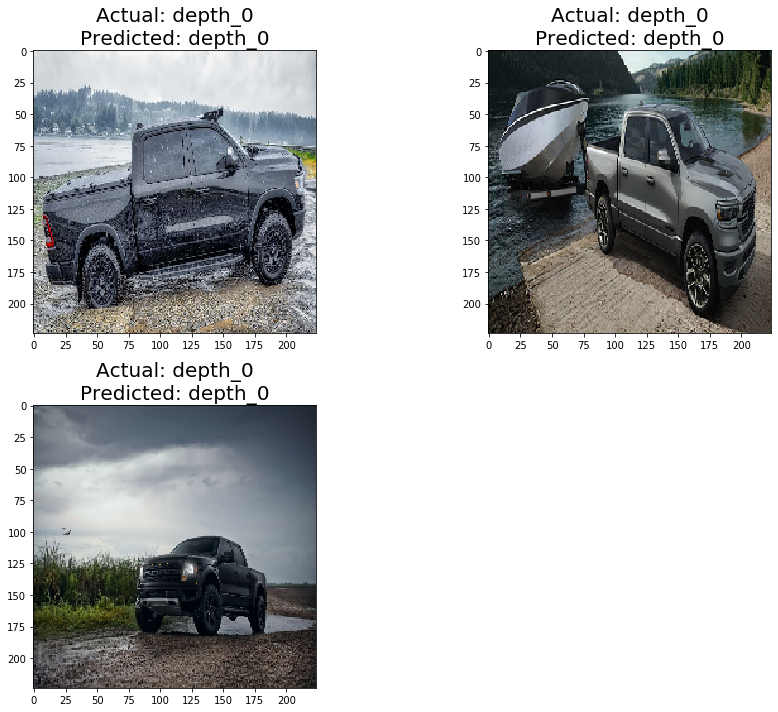

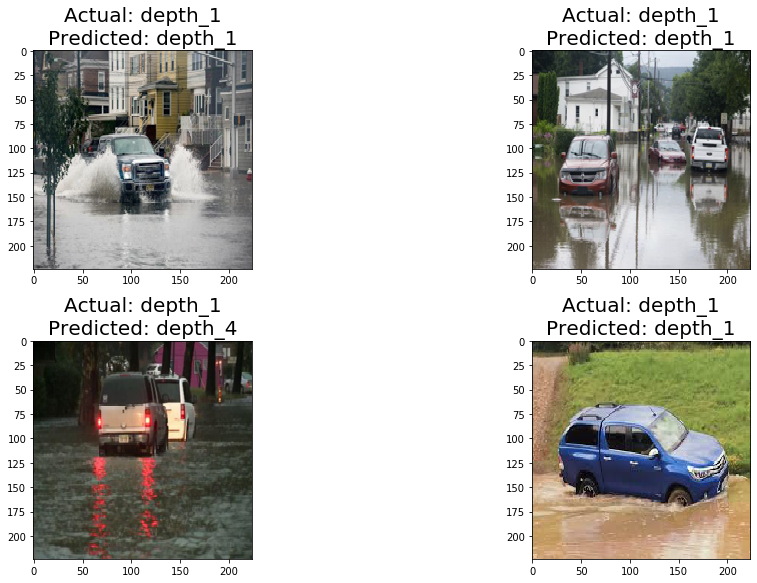

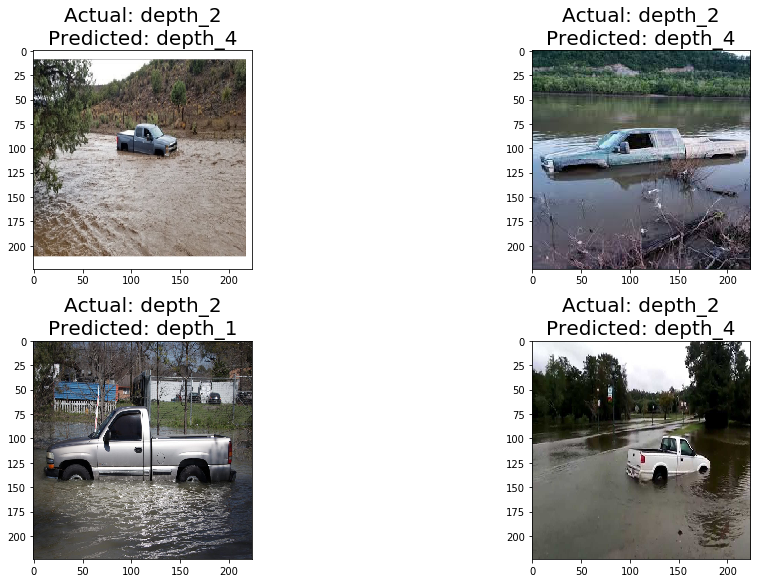

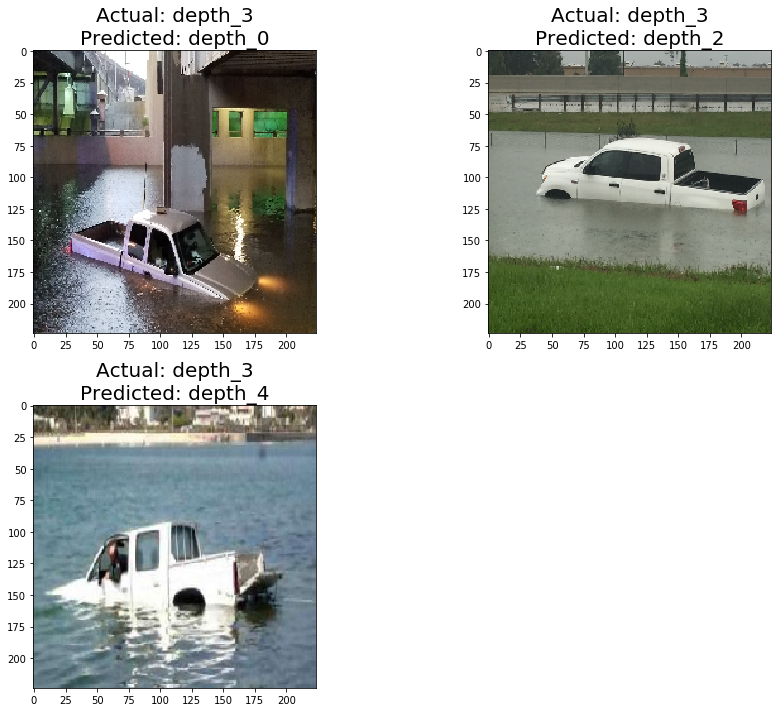

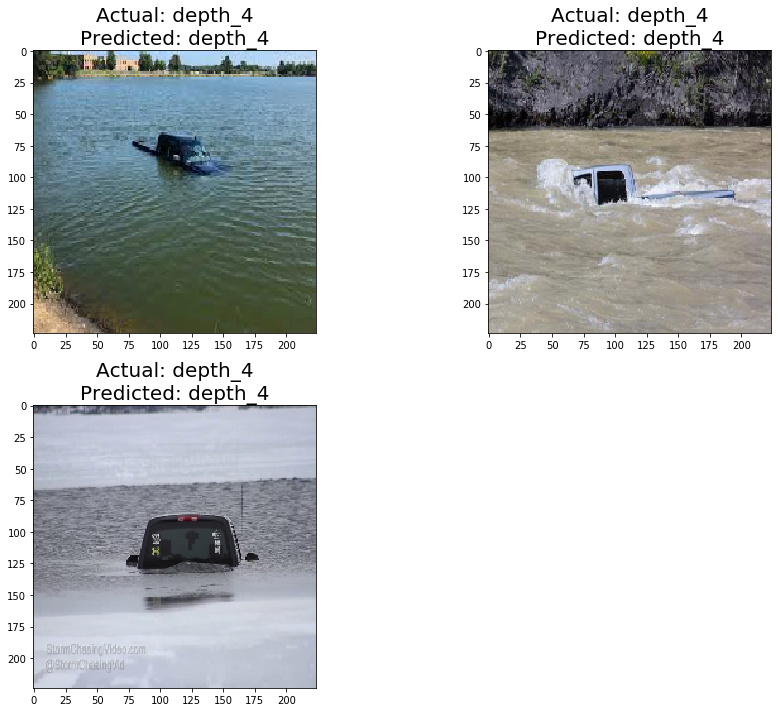

In [25]:
for caty in labels:
    category_dir = image_test_dir + '/' + caty
    img_list = rm_DS(os.listdir(category_dir))
    print(f"Category {caty} has {len(img_list)} test images.")
    evaluate_test_images(caty,category_dir,img_list)